In [1]:
import numpy as np
import pandas as pd
import numpy
import matplotlib.pyplot as plt

#Fix colormath depreciated numpy method
def patch_asscalar(a):
    return a.item()
setattr(numpy, "asscalar", patch_asscalar)

#Import data
all_colors = pd.read_csv("data/all-colors.csv")
chosen_colors = pd.read_csv("data/chosen-colors.csv")

#Remove chosen colors
condition = all_colors["Shirt Color Name"].isin(chosen_colors["Shirt Color"])
remaining_colors = all_colors.drop(all_colors[condition].index, inplace=False)

#Confirm removal
# print(len(remaining_colors))
# print(len(all_colors))
# print(len(chosen_colors))

In [2]:
import colormath.color_objects as co
import colormath.color_diff as cdiff

def compute_average_distance(row):
    color_Lab = None

    color_Lab = co.LabColor(*map(float, row["L*a*b Value"].split(", ")))

    distances = []

    #Compute all distances from chosen colors
    for index, row_remaining in chosen_colors.iterrows():
        other_color = co.LabColor(*map(float, row_remaining["L*a*b Value"].split(", ")))

        #Newer, asymmetric formula, weighted for fabrics, using
        #distance = cdiff.delta_e_cmc(other_color, color_Lab , pl=2, pc=1)

        #Older symmetric formula, weighted for fabrics
        distance = cdiff.delta_e_cie2000(color_Lab, other_color,Kl=2, Kc=1, Kh=1)

        distances += [distance]

    average_distance = sum(distances)/len(remaining_colors)

    row["Distance"] = average_distance
    return row

remaining_colors = remaining_colors.apply(compute_average_distance, axis=1)

In [3]:
sorted_remaining = remaining_colors.sort_values(by = "Distance", ascending=False)
sorted_remaining.iloc[:].head(10)

,Shirt Color Name,PMS Color Code,L*a*b Value,Hex,Distance
47,Teal,3262C,"66.44, -59.33, -12.05",00BFB2,7.545582
73,Heather Kelly,340 C,"51.80, -65.36, 14.55",00965E,7.436395
50,Turquoise,638C,"63.99, -33.79, -34.95",00AFD7,7.312165
24,Maize Yellow,7548CP,"83.14, 5.01, 85.02",F2CA00,7.287751
104,Heather Yellow,100 CP,"92.09, -6.83, 62.42",F6EB69,7.094500
96,Heather Sea Green,2398 C,"66.81, -46.18, -10.83",00BAB3,6.989276
37,Poppy,2347C,"49.45, 75.12, 67.21",E10600,6.858418
20,Kelly,341C,"43.23, -48.36, 9.96",007A53,6.852545
83,Heather Orange,1645 C,"65.69, 58.38, 58.65",FF6A39,6.630476
34,Orange,1645C,"65.69, 58.38, 58.65",FF6A39,6.630476


In [4]:
chosen_colors.to_json(orient="records")

'[{"Shirt Color":"Heather Ice Blue","Pantone Color":"317 CP","L*a*b Value":"85.65, -11.38, -2.20","HEX":"BDDDD9"},{"Shirt Color":"Berry","Pantone Color":"233 CP","L*a*b Value":"45.38, 71.84, -7.30","HEX":"C6057B"},{"Shirt Color":"Oxblood Black","Pantone Color":"7449 CP","L*a*b Value":"28.13, 16.23, -6.49","HEX":"55394D"},{"Shirt Color":"White","Pantone Color":"White C","L*a*b Value":"100, 0, 0","HEX":"FFFFFF"},{"Shirt Color":"Ash","Pantone Color":"428 CP","L*a*b Value":"78.50, -2.14, -0.31","HEX":"BDC4C2"},{"Shirt Color":"Gold","Pantone Color":"137 C","L*a*b Value":"76.47, 31.14, 81.64","HEX":"FFA400"},{"Shirt Color":"Yellow","Pantone Color":"100 CP","L*a*b Value":"92.09, -6.83, 62.42","HEX":"F6EB69"},{"Shirt Color":"Deep Teal","Pantone Color":"3025 CP","L*a*b Value":"32.45, -23.19, -27.24","HEX":"005876"},{"Shirt Color":"Heather Maroon","Pantone Color":"7644 CP","L*a*b Value":"27.76, 25.21, -2.86","HEX":"603147"},{"Shirt Color":"Evergreen","Pantone Color":"343 C","L*a*b Value":"31.90,

In [5]:
#Orange to Gold

orange = all_colors[all_colors["Shirt Color Name"] == "Orange"]
gold = all_colors[all_colors["Shirt Color Name"] == "Gold"]
burnt_orange = all_colors[all_colors["Shirt Color Name"] == "Burnt Orange"]

comparison_list = [gold, orange, burnt_orange]

comparison_matrix = [[0]*3 for i in range(3)]

for i in range(len(comparison_list)):
    for j in range(len(comparison_matrix)):
        #I really should just fix the tables
        target_color = co.LabColor(*map(float,comparison_list[i].iloc[0]["L*a*b Value"].split(", ")))
        comparison_color = co.LabColor(*map(float,comparison_list[j].iloc[0]["L*a*b Value"].split(", ")))

        #Newer formula
        distance = cdiff.delta_e_cmc(target_color, comparison_color, pl=2, pc=1)

        comparison_matrix[i][j] = distance

print("    Gold    Orange    Burnt Orange")
for row in comparison_matrix:
    print(row)

    Gold    Orange    Burnt Orange
[0.0, 24.24013342020266, 17.480586695643115]
[26.402279861193914, 0.0, 9.887678740145626]
[22.286845806880518, 11.611165190695397, 0.0]


In [18]:
import networkx as nx

# Let's make an adjacency matrix representing color distances to/from each other
adjacency_matrix = pd.DataFrame(np.zeros(shape=(16, 16)),
columns = chosen_colors["Shirt Color"].unique(), index=chosen_colors["Shirt Color"].unique())

for index_a, row_a in chosen_colors.iterrows():
    for index_b, row_b in chosen_colors.iterrows():
        color_a = co.LabColor(*map(float, row_a["L*a*b Value"].split(", ")))
        color_b = co.LabColor(*map(float, row_b["L*a*b Value"].split(", ")))

        distance = cdiff.delta_e_cie2000(color_a, color_b, Kl=2, Kc=1, Kh=1)

        adjacency_matrix.at[row_a["Shirt Color"], row_b["Shirt Color"]] = distance

import json
adjacency_matrix.head()

data_dict = adjacency_matrix.to_dict(orient="records")

first_item = data_dict[0]

future_json = []
for item in data_dict:
    future_json += [list(item.values())]

for item in future_json:
    print(item)

json.dumps(future_json)


[0.0, 30.424428518806256, 39.820442187682616, 13.139849641797058, 9.861525472765411, 37.17207450674439, 29.531588108080946, 28.06010910891849, 41.661806301274, 26.482537194432258, 46.809672059173906, 18.284646673736457, 28.836770533128508, 34.503806731128996, 31.4770454304642, 41.150185006319695]
[30.42442851880625, 0.0, 20.18846670568939, 34.44222786730989, 20.736301709761626, 51.62924244963271, 64.82675026612675, 63.787287385502516, 16.42882784859399, 63.97498572388569, 18.85083864220356, 58.93470453956385, 28.004707554845396, 39.070684776673666, 25.879431579656593, 32.06532304123741]
[39.820442187682616, 20.18846670568939, 0.0, 33.92846017952043, 30.876864112568178, 45.47035893419028, 51.09746120884817, 44.11054573392831, 5.941927401896447, 37.96186025669787, 25.04815126201635, 42.01271781398227, 28.278047627146215, 25.318982666824898, 21.989242434439994, 18.437280324959687]
[13.139849641797058, 34.44222786730989, 33.92846017952043, 0.0, 7.419069844065856, 30.40436360741453, 26.1354

'[[0.0, 30.424428518806256, 39.820442187682616, 13.139849641797058, 9.861525472765411, 37.17207450674439, 29.531588108080946, 28.06010910891849, 41.661806301274, 26.482537194432258, 46.809672059173906, 18.284646673736457, 28.836770533128508, 34.503806731128996, 31.4770454304642, 41.150185006319695], [30.42442851880625, 0.0, 20.18846670568939, 34.44222786730989, 20.736301709761626, 51.62924244963271, 64.82675026612675, 63.787287385502516, 16.42882784859399, 63.97498572388569, 18.85083864220356, 58.93470453956385, 28.004707554845396, 39.070684776673666, 25.879431579656593, 32.06532304123741], [39.820442187682616, 20.18846670568939, 0.0, 33.92846017952043, 30.876864112568178, 45.47035893419028, 51.09746120884817, 44.11054573392831, 5.941927401896447, 37.96186025669787, 25.04815126201635, 42.01271781398227, 28.278047627146215, 25.318982666824898, 21.989242434439994, 18.437280324959687], [13.139849641797058, 34.44222786730989, 33.92846017952043, 0.0, 7.419069844065856, 30.40436360741453, 26

KeyError: 'color'

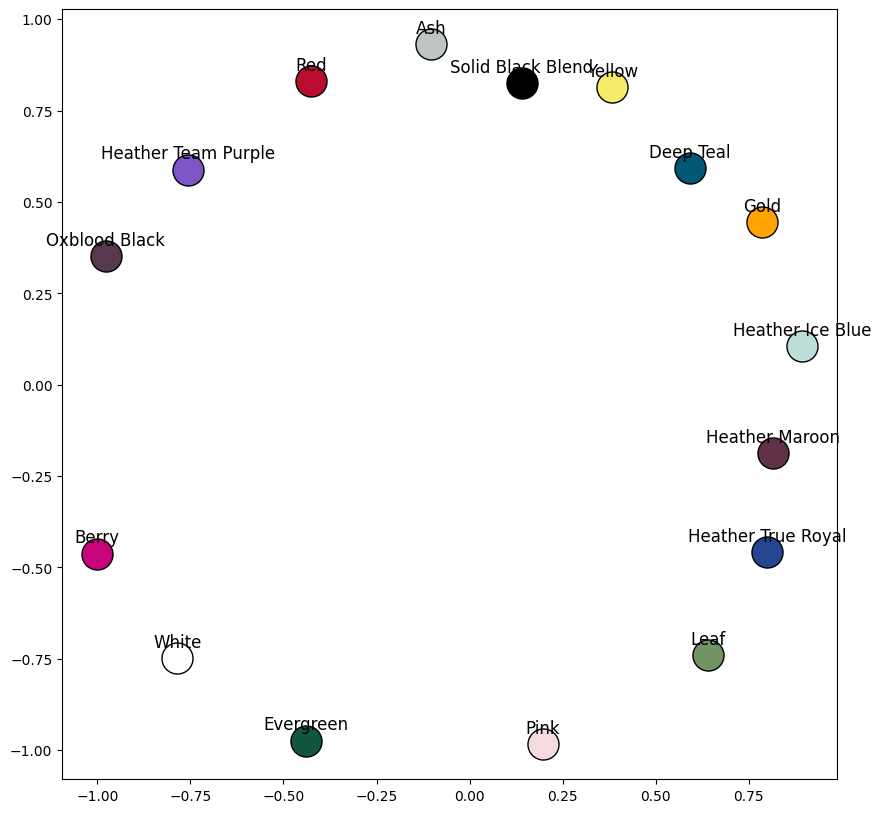

In [7]:

node_color_list = ("#" + chosen_colors["HEX"]).tolist()

G = nx.Graph()

for index, color in chosen_colors.iterrows():
    G.add_node(
        index,
        label=color["Shirt Color"],
        color="#"+color["HEX"]
    )

for index_a, row_a in chosen_colors.iterrows():
    for index_b, row_b in chosen_colors.iterrows():
        weight_val = adjacency_matrix.at[row_a["Shirt Color"], row_b["Shirt Color"]]

        G.add_edge(row_a["Shirt Color"], row_b["Shirt Color"], weight=weight_val)

pos = nx.spring_layout(G, weight="weight")

plt.figure(figsize=(10, 10))
for node, (x, y) in pos.items():
    # Draw nodes as colored circles
    plt.scatter(x, y, c=G.nodes[node]["color"], s=500, edgecolors="black", zorder=2)
    # Add text labels
    plt.text(
        x,
        y + 0.03,
        G.nodes[node]["label"],
        horizontalalignment="center",
        fontsize=12,
        zorder=3,
    )

# for (u, v, d) in G.edges(data=True):
#     plt.plot(
#         [pos[u][0], pos[v][0]],
#         [pos[u][1], pos[v][1]],
#         "gray",
#         alpha=max(0.2, 1 - d["weight"]),
#         zorder=1,
#     )

plt.axis("off")
plt.title("Color Graph Visualization")
plt.show()
G.nodes.items()

#A = nx.nx_agraph.to_agraph(G)
#lab_color = co.LabColor()